# set up packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("moive analysis").config("spark.some.config.option", "some-value").getOrCreate()

# load data

In [4]:
location = "D:/py_movie_recommendation_system/data/"

In [5]:
# ratings.csv is the training data, movies.csv is to help find
movies_df = spark.read.load(location+"movies.csv", format='csv', header = True)
ratings_df = spark.read.load(location+"ratings.csv", format='csv', header = True)
links_df = spark.read.load(location+"links.csv", format='csv', header = True)
tags_df = spark.read.load(location+"tags.csv", format='csv', header = True)

In [6]:
# overview
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [7]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [8]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [9]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [10]:
# check the min number of ratings for per user and per movie
tmp1 = ratings_df.groupBy("userID").count().agg({'count':'min'}).toPandas()
tmp2 = ratings_df.groupBy("movieId").count().agg({'count':'min'}).toPandas()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1.iloc[0,0]))
print('Minimum number of ratings per movie is {}'.format(tmp2.iloc[0,0]))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [11]:
tmp3 = ratings_df.groupBy("movieId").count().where('count=1').count()
tmp4 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp3, tmp4))

3446 out of 9724 movies are rated by only one user


# EDA

In [12]:
# make all data into tables
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
links_df.createOrReplaceTempView("links")
tags_df.createOrReplaceTempView("tags")

## number of users

In [13]:
# here the users come from two sections, ratings and tags
# however there are still user who did not add tag or rate a movie but we can ignore those part since we cannot find them based on bd
number_user = spark.sql(
    '''
    SELECT COUNT(DISTINCT userID)
    FROM (
        SELECT DISTINCT userID
        FROM ratings

        UNION

        SELECT DISTINCT userID
        FROM tags
    )
    '''
).toPandas()
print("Total number of users we can observe is ", number_user.iloc[0, 0])

Total number of users we can observe is  610


## number of movies

In [14]:
# the movie table should have all the movie data we need
# but to make sure, we include all tables that have movieId column
number_movie = spark.sql(
    """
    SELECT COUNT(DISTINCT movieId)
    FROM (
        SELECT DISTINCT movieId
        FROM movies

        UNION

        SELECT DISTINCT movieId
        FROM ratings

        UNION

        SELECT DISTINCT movieId
        FROM links

        UNION

        SELECT DISTINCT movieId
        FROM tags
    )
    """
).toPandas()
print("Total number of movies in database is ", number_movie.iloc[0, 0])

Total number of movies in database is  9742


# how many movies have been rated, and which movie has not been rated?

In [15]:
# number of movie rated
number_rated = spark.sql(
    """
    SELECT COUNT(DISTINCT a.movieId)
    FROM movies as a
    JOIN ratings as b
    ON a.movieId = b.movieId
    """
).toPandas()
print("Total number of movies that have been rated is ", number_rated.iloc[0, 0])
print("There are {} movies have not been rated before.".format(number_movie.iloc[0, 0] - number_rated.iloc[0, 0]))

Total number of movies that have been rated is  9724
There are 18 movies have not been rated before.


In [16]:
# based on the dataset we know there are 18 movies not being rated, we gonna check for that and print some basic information
unrated = spark.sql(
    """
    SELECT *
    FROM movies
    WHERE movieId NOT IN (
        SELECT movieId
        FROM ratings
    )
    """
).toPandas()
print("Total number of movies that have not been rated is ", unrated.shape[0])
print("Their basic information are as follows:")
unrated

Total number of movies that have not been rated is  18
Their basic information are as follows:


,movieId,title,genres
0,1076,"Innocents, The (1961)",Drama|Horror|Thriller
1,2939,Niagara (1953),Drama|Thriller
2,3338,For All Mankind (1989),Documentary
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
4,4194,I Know Where I'm Going! (1945),Drama|Romance|War
5,5721,"Chosen, The (1981)",Drama
6,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
7,6849,Scrooge (1970),Drama|Fantasy|Musical
8,7020,Proof (1991),Comedy|Drama|Romance
9,7792,"Parallax View, The (1974)",Thriller


# top 100 movies

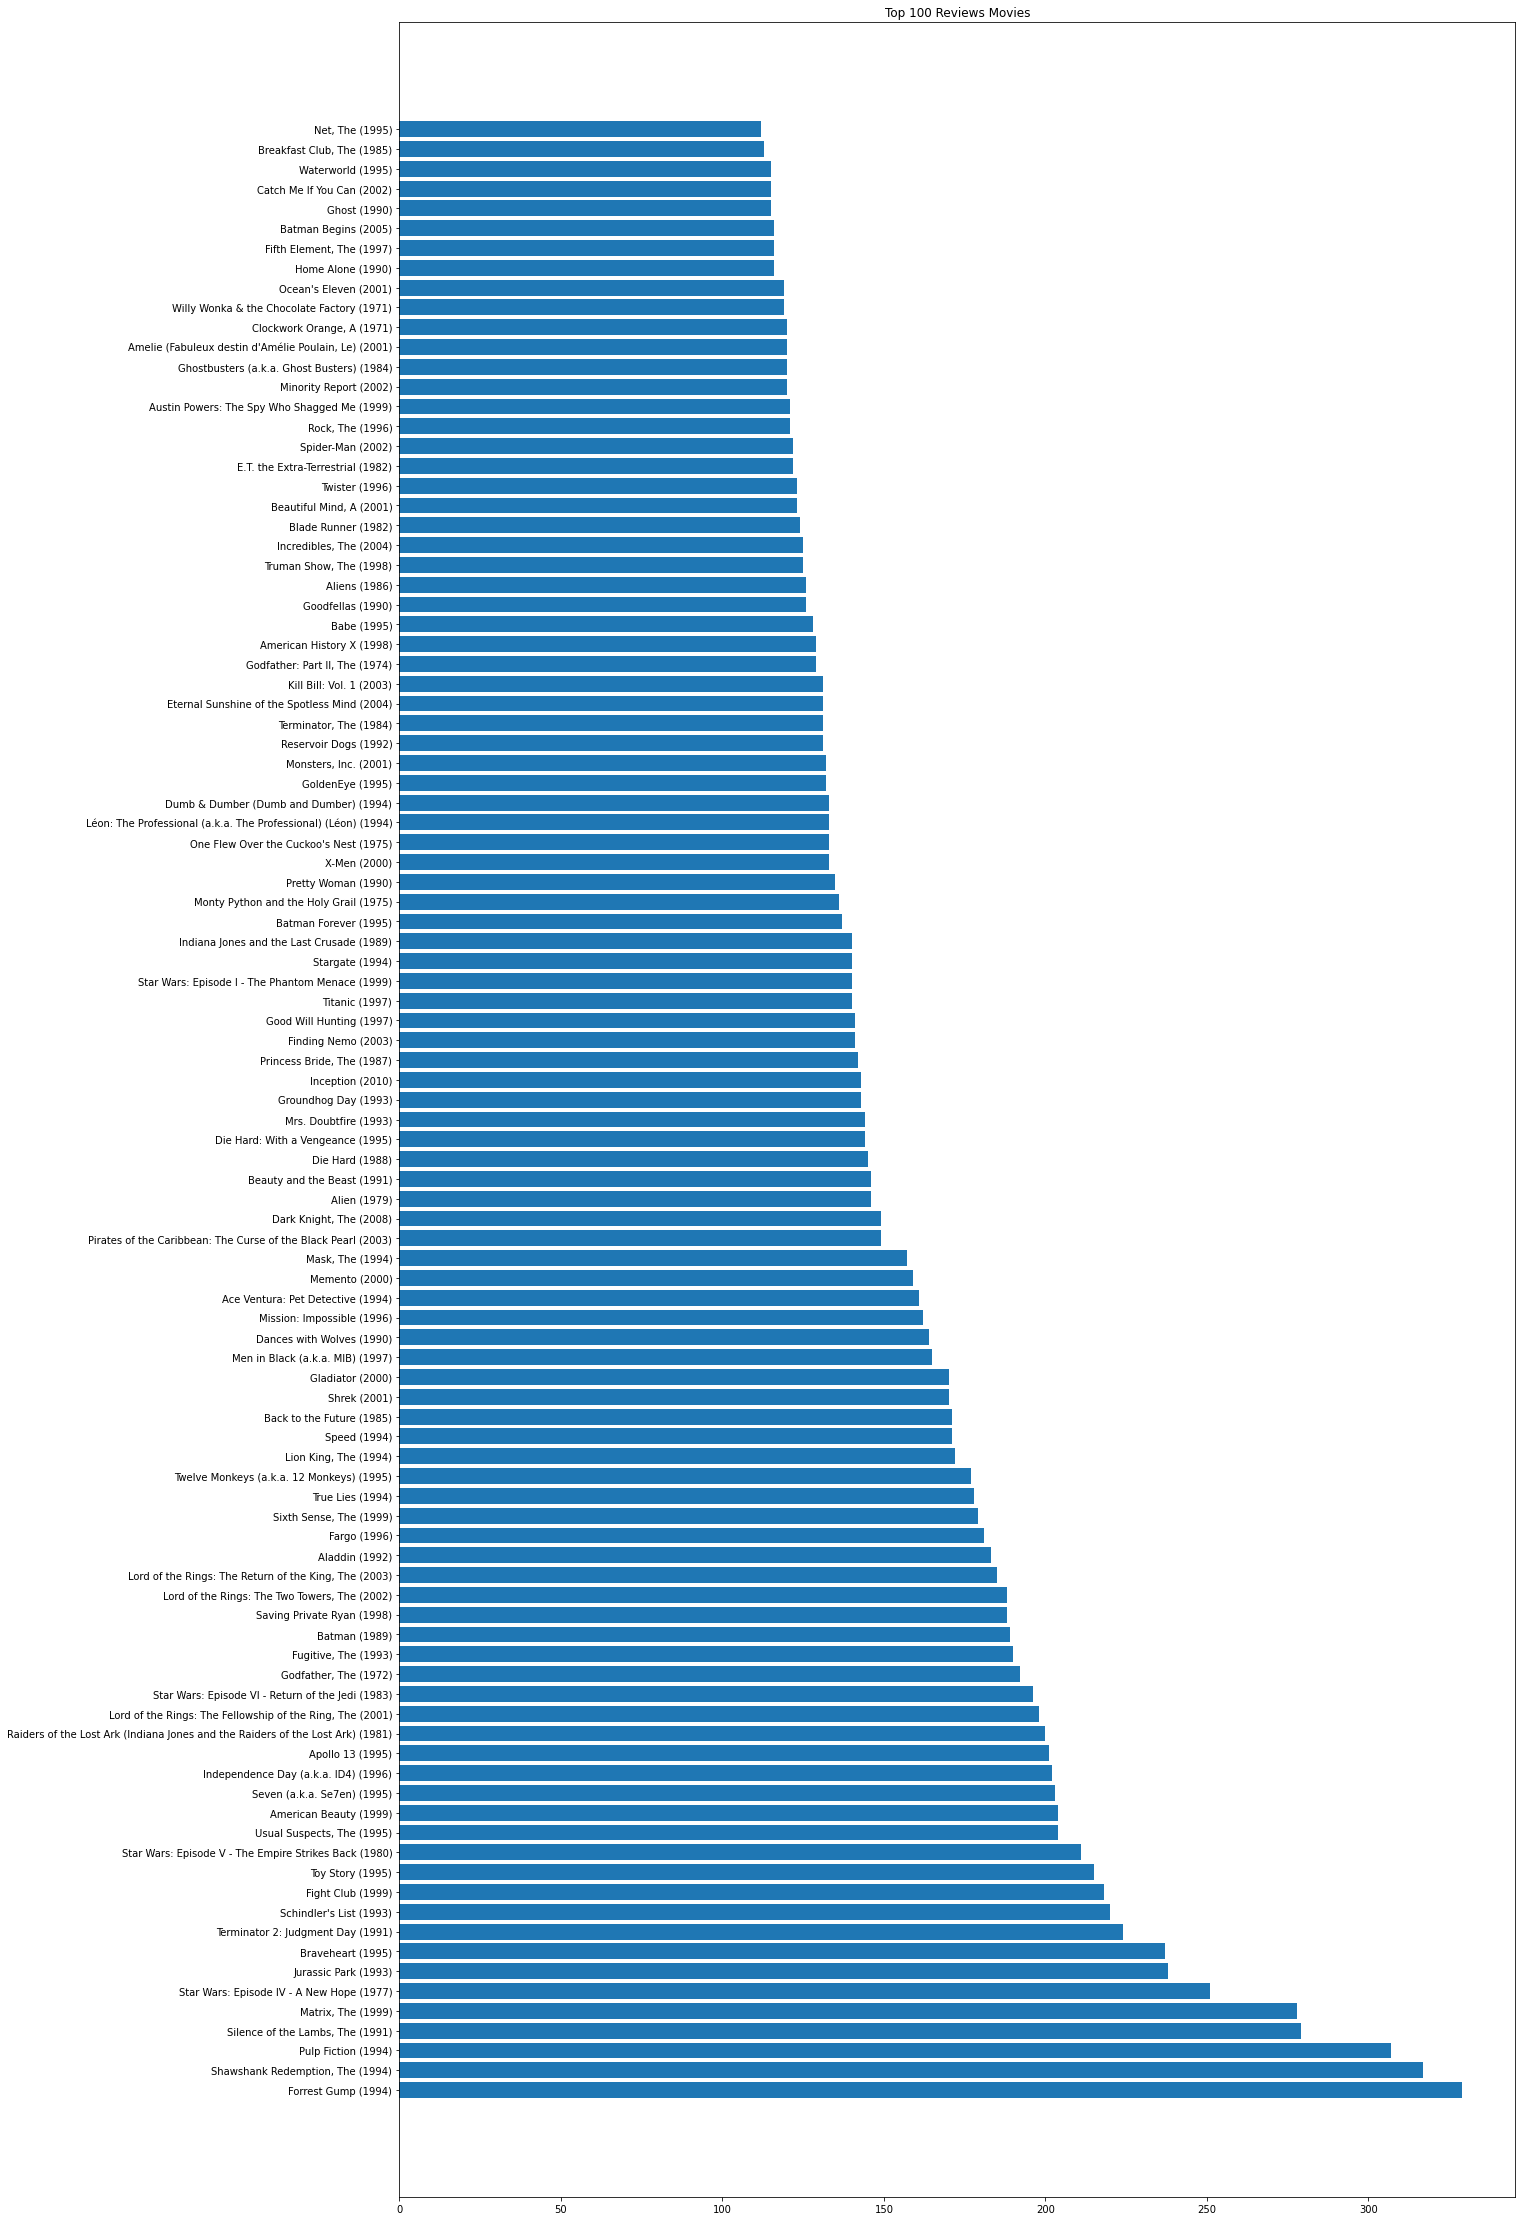

In [17]:
# first we define the top 100 movies by its number of reviews
top_number_reviews = spark.sql(
    """
    SELECT title, SUM(rated) AS count
    FROM (
        SELECT a.title,
            CASE WHEN rating IS NULL THEN 0 ELSE 1 END AS rated
        FROM movies AS a
        LEFT JOIN ratings AS b
        ON a.movieId = b.movieId
    )
    GROUP BY title
    ORDER BY count DESC
    LIMIT 100
    """
).toPandas()
plt.figure(figsize = [20, 40])
plt.barh(y = 'title', width = 'count', data = top_number_reviews)
plt.title("Top 100 Reviews Movies")
plt.show()

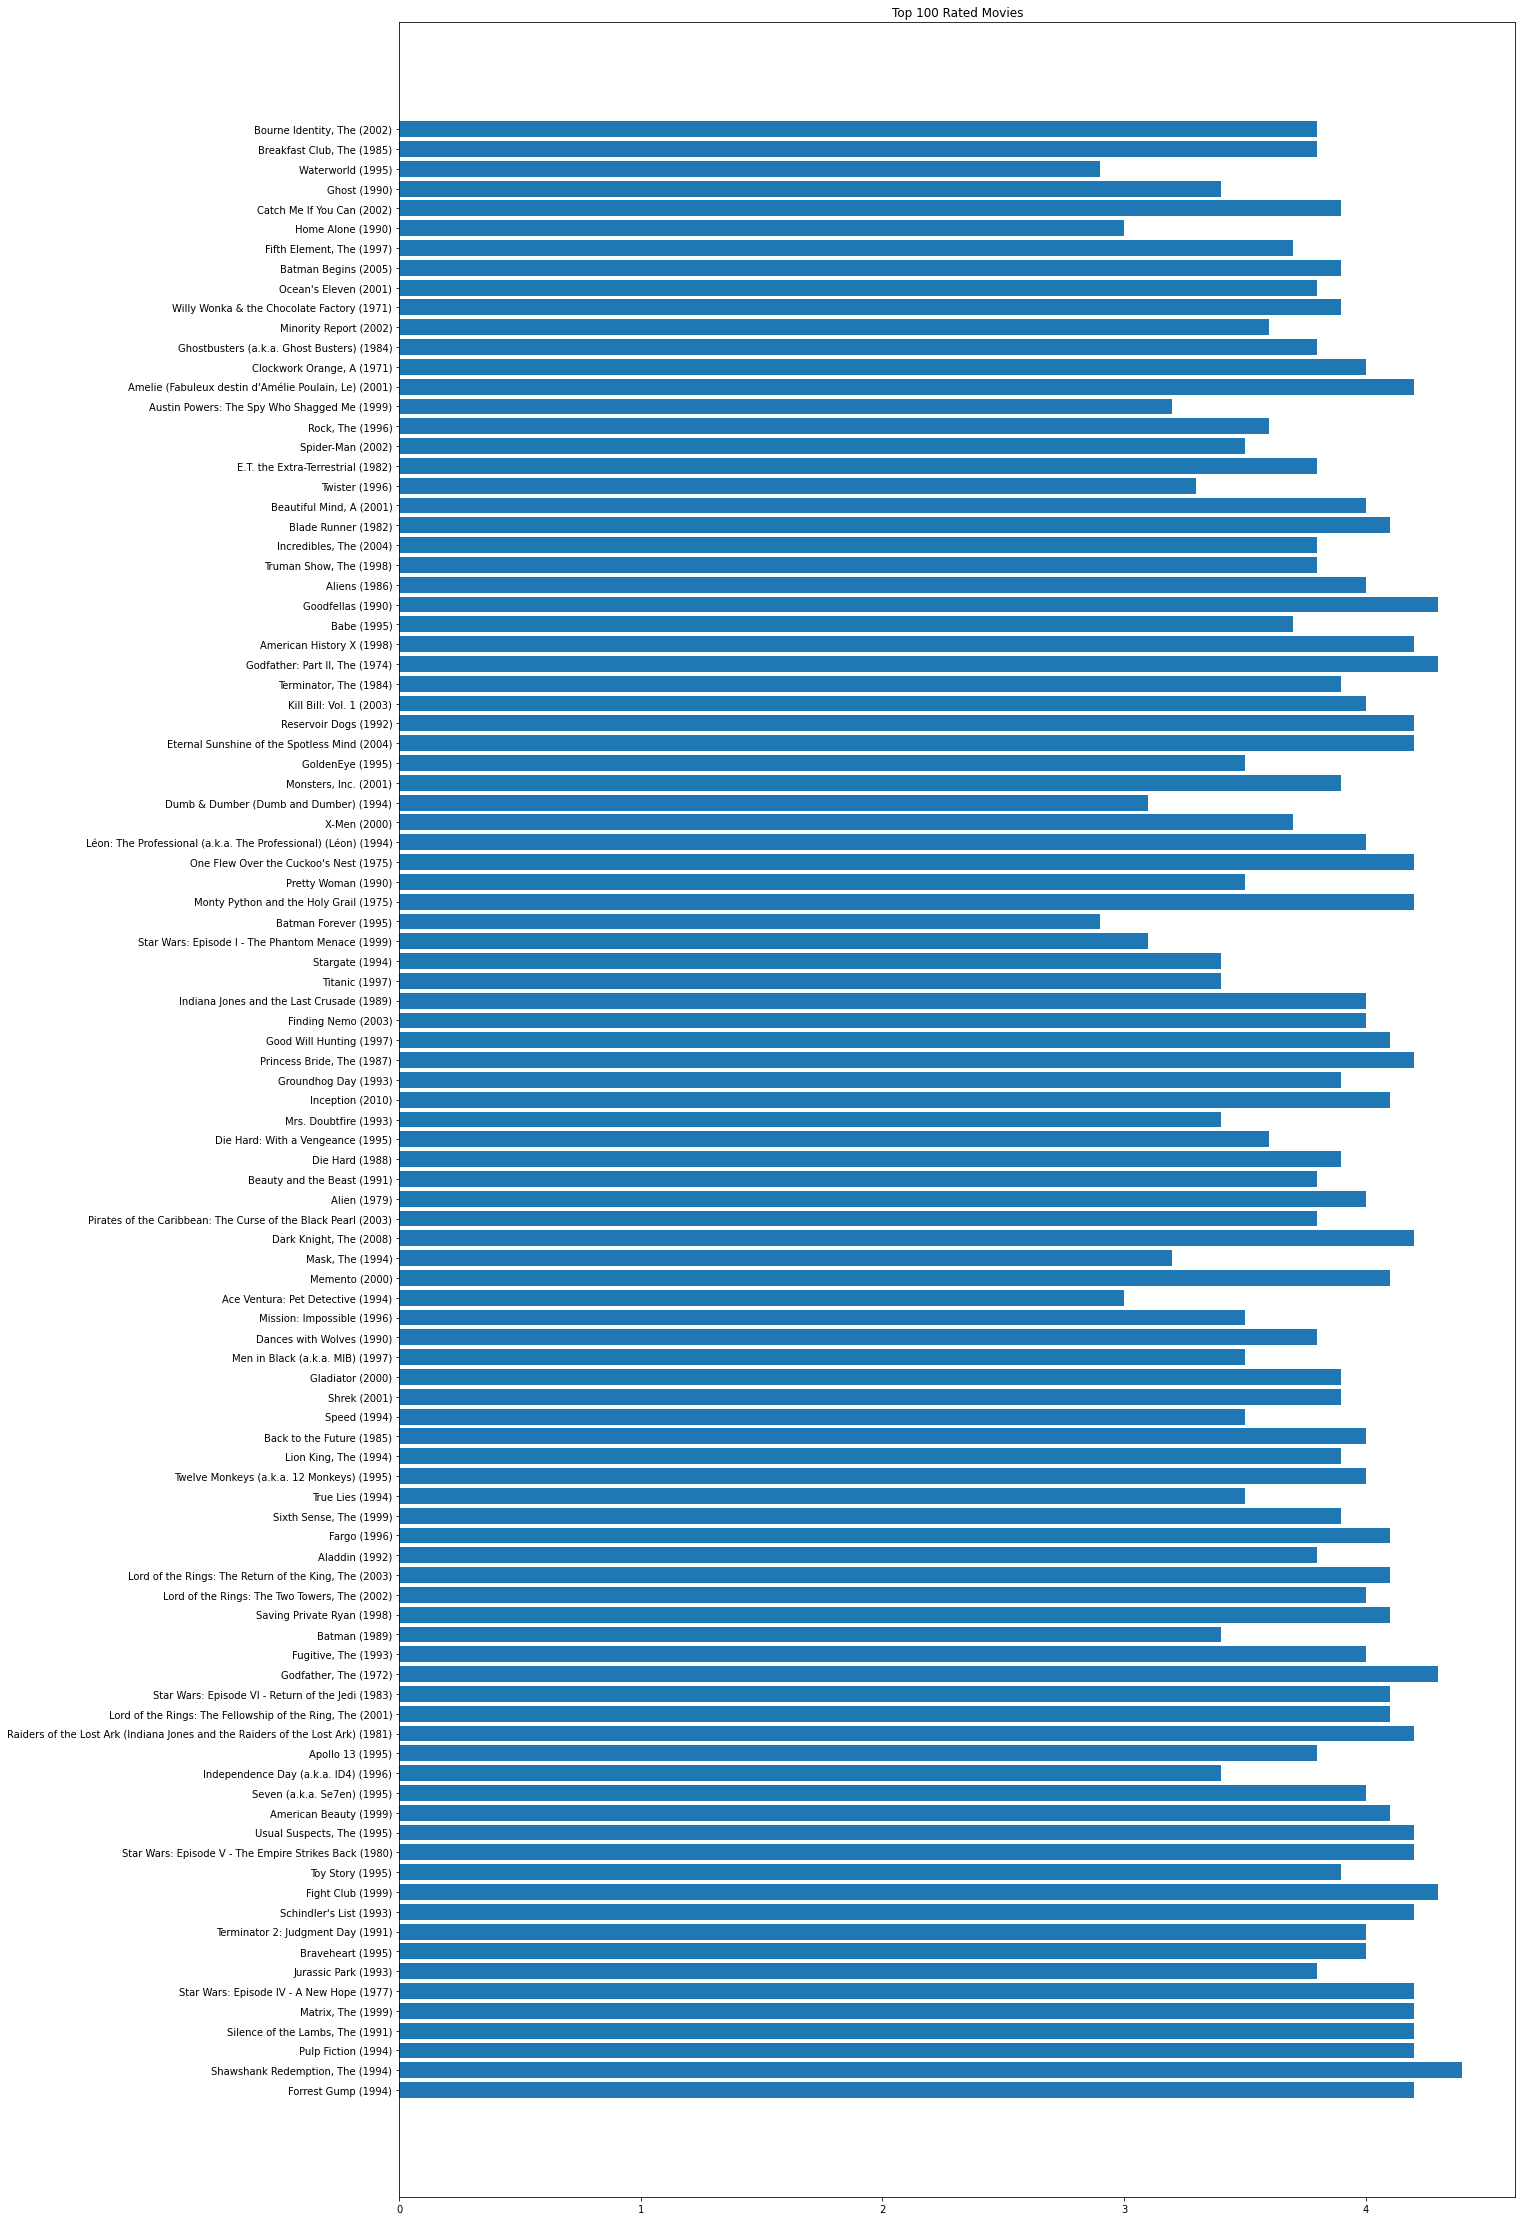

In [18]:
# then we define the top 100 movies based on its ratings
# first we define the top 100 movies by its number of reviews
top_rated = spark.sql(
    """
    SELECT a.title, ROUND(AVG(b.rating), 1) AS rate,
        SUM(CASE WHEN b.rating IS NULL THEN 0 ELSE 1 END) AS count
    FROM movies AS a
    LEFT JOIN ratings AS b
    ON a.movieId = b.movieId
    GROUP BY a.title
    ORDER BY count DESC, rate DESC
    LIMIT 100
    """
).toPandas()
plt.figure(figsize = [20, 40])
plt.barh(y = 'title', width = 'rate', data = top_rated)
plt.title("Top 100 Rated Movies")
plt.show()

# movie genres

In [19]:
# get all genres
genres_list=spark.sql('select genres from movies').toPandas()
spark.sql('select distinct genres from movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [20]:
# however, this kind of genres is useless we need to split them
genres_list=genres_list['genres'].str.get_dummies(sep='|').astype(np.int64)
print(pd.DataFrame(genres_list.columns,columns=['genres_list']))

           genres_list
0   (no genres listed)
1               Action
2            Adventure
3            Animation
4             Children
5               Comedy
6                Crime
7          Documentary
8                Drama
9              Fantasy
10           Film-Noir
11              Horror
12                IMAX
13             Musical
14             Mystery
15             Romance
16              Sci-Fi
17            Thriller
18                 War
19             Western


# movie for each genres

In [21]:
# by one hot encoding
movies_df0 = pd.concat([movies_df.select('movieId','title').toPandas(), genres_list],axis=1)
genre_count = movies_df0.iloc[:,2:].sum().sort_values(ascending=False).reset_index()
genre_count.columns = ['category', 'number']
genre_count

,category,number
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


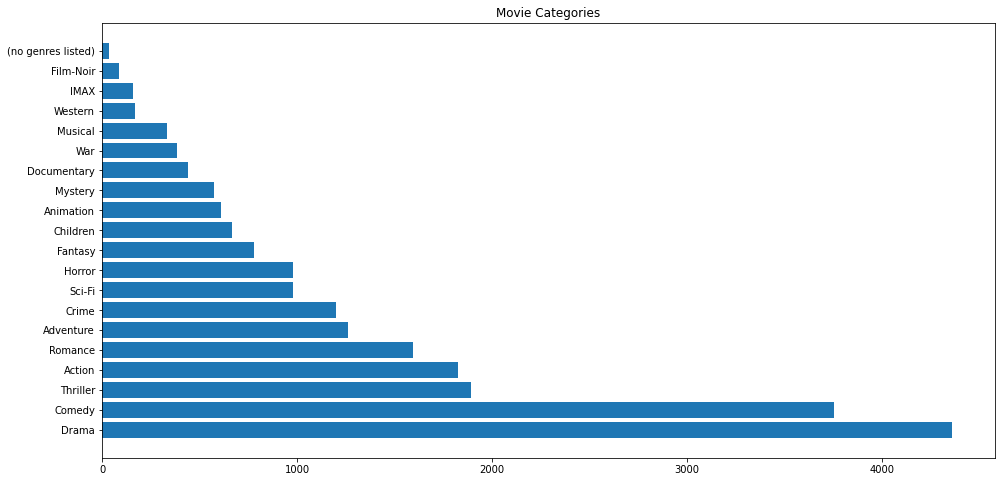

In [22]:
plt.figure(figsize = [16,8])
plt.barh(y = 'category', width = 'number', data = genre_count)
plt.title('Movie Categories')
plt.show()

# Ratings distribution

In [23]:
movie_ratings=ratings_df.drop('timestamp')
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

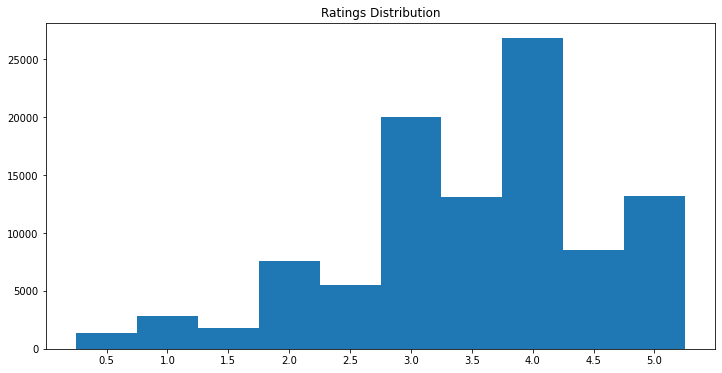

In [24]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()